In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import plotly.graph_objects as go

In [2]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")

In [3]:
train['date'] = pd.to_datetime(train['date']).dt.to_period('D')
#train = train.set_index('date') 

In [4]:
train.head(18)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   id        136950 non-null  int64    
 1   date      136950 non-null  period[D]
 2   country   136950 non-null  object   
 3   store     136950 non-null  object   
 4   product   136950 non-null  object   
 5   num_sold  136950 non-null  int64    
dtypes: int64(2), object(3), period[D](1)
memory usage: 6.3+ MB


In [6]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Enc_col = ['country', 'store', 'product' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: country
  Wartość zakodowana: 0 -> Wartość początkowa: Argentina
  Wartość zakodowana: 1 -> Wartość początkowa: Canada
  Wartość zakodowana: 2 -> Wartość początkowa: Estonia
  Wartość zakodowana: 3 -> Wartość początkowa: Japan
  Wartość zakodowana: 4 -> Wartość początkowa: Spain
Kolumna: store
  Wartość zakodowana: 0 -> Wartość początkowa: Kagglazon
  Wartość zakodowana: 1 -> Wartość początkowa: Kaggle Learn
  Wartość zakodowana: 2 -> Wartość początkowa: Kaggle Store
Kolumna: product
  Wartość zakodowana: 0 -> Wartość początkowa: Using LLMs to Improve Your Coding
  Wartość zakodowana: 1 -> Wartość początkowa: Using LLMs to Train More LLMs
  Wartość zakodowana: 2 -> Wartość początkowa: Using LLMs to Win Friends and Influence People
  Wartość zakodowana: 3 -> Wartość początkowa: Using LLMs to Win More Kaggle Competitions
  Wartość zakodowana: 4 -> Wartość początkowa: Using LLMs to Write Better


In [7]:
train = train.drop(columns=['country', 'store', 'product'])
Argentina  = train[train['country_Enc'] == 0]
Canada     = train[train['country_Enc'] == 1]
Estonia    = train[train['country_Enc'] == 2]
Japan      = train[train['country_Enc'] == 3]
Japan      = train[train['country_Enc'] == 4]
Argentina  = Argentina.drop(columns= 'country_Enc')

In [8]:
Argentina.head()

,id,date,num_sold,store_Enc,product_Enc
0,0,2017-01-01,63,1.0,0.0
1,1,2017-01-01,66,1.0,1.0
2,2,2017-01-01,9,1.0,2.0
3,3,2017-01-01,59,1.0,3.0
4,4,2017-01-01,49,1.0,4.0


In [9]:
multi_index = pd.MultiIndex.from_frame(Argentina[['date' , 'id']], names =  ['date' , 'id'])
Argentina.set_index(multi_index, inplace=True)
Argentina = Argentina.drop(columns=['id', 'date'])

In [10]:
import itertools

store_codes = Argentina['store_Enc'].unique()
product_codes = Argentina['product_Enc'].unique()

# Filter valid combinations based on existing data
valid_combos = [(s, p) for s in store_codes for p in product_codes]
# Create new column names from the valid combinations
new_column_names = [f'store_{s}_product_{p}' for s, p in valid_combos]
combo_df = pd.DataFrame(columns=new_column_names)

def fill_values(argentina_df, combine_df, target_cols=None):
  num_sold_values = argentina_df['num_sold'].values

  # Calculate the required number of rows
  num_rows = len(num_sold_values) // len(combine_df.columns)
  if len(num_sold_values) % len(combine_df.columns) != 0:
    raise ValueError("Number of 'num_sold' values not evenly divisible by number of columns in combo_df")

  # Create a new DataFrame with the required shape
  filled_df = pd.DataFrame(index=range(num_rows), columns=combine_df.columns)

  # Fill the values
  for row_num in range(num_rows):
    start_idx = row_num * len(combine_df.columns)
    end_idx = start_idx + len(combine_df.columns)
    if target_cols is None:
      filled_df.iloc[row_num, :] = num_sold_values[start_idx:end_idx]
    else:
      for col in target_cols:
        if col in combine_df.columns:
          filled_df.loc[row_num, col] = num_sold_values[start_idx:end_idx]
        else:
          print(f"Column '{col}' not found in combo_df")

  return filled_df

# Call the function and assign the result to 'df'
df = fill_values(Argentina, combo_df)


df.index = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.select_dtypes(include=['number']).astype('int32')

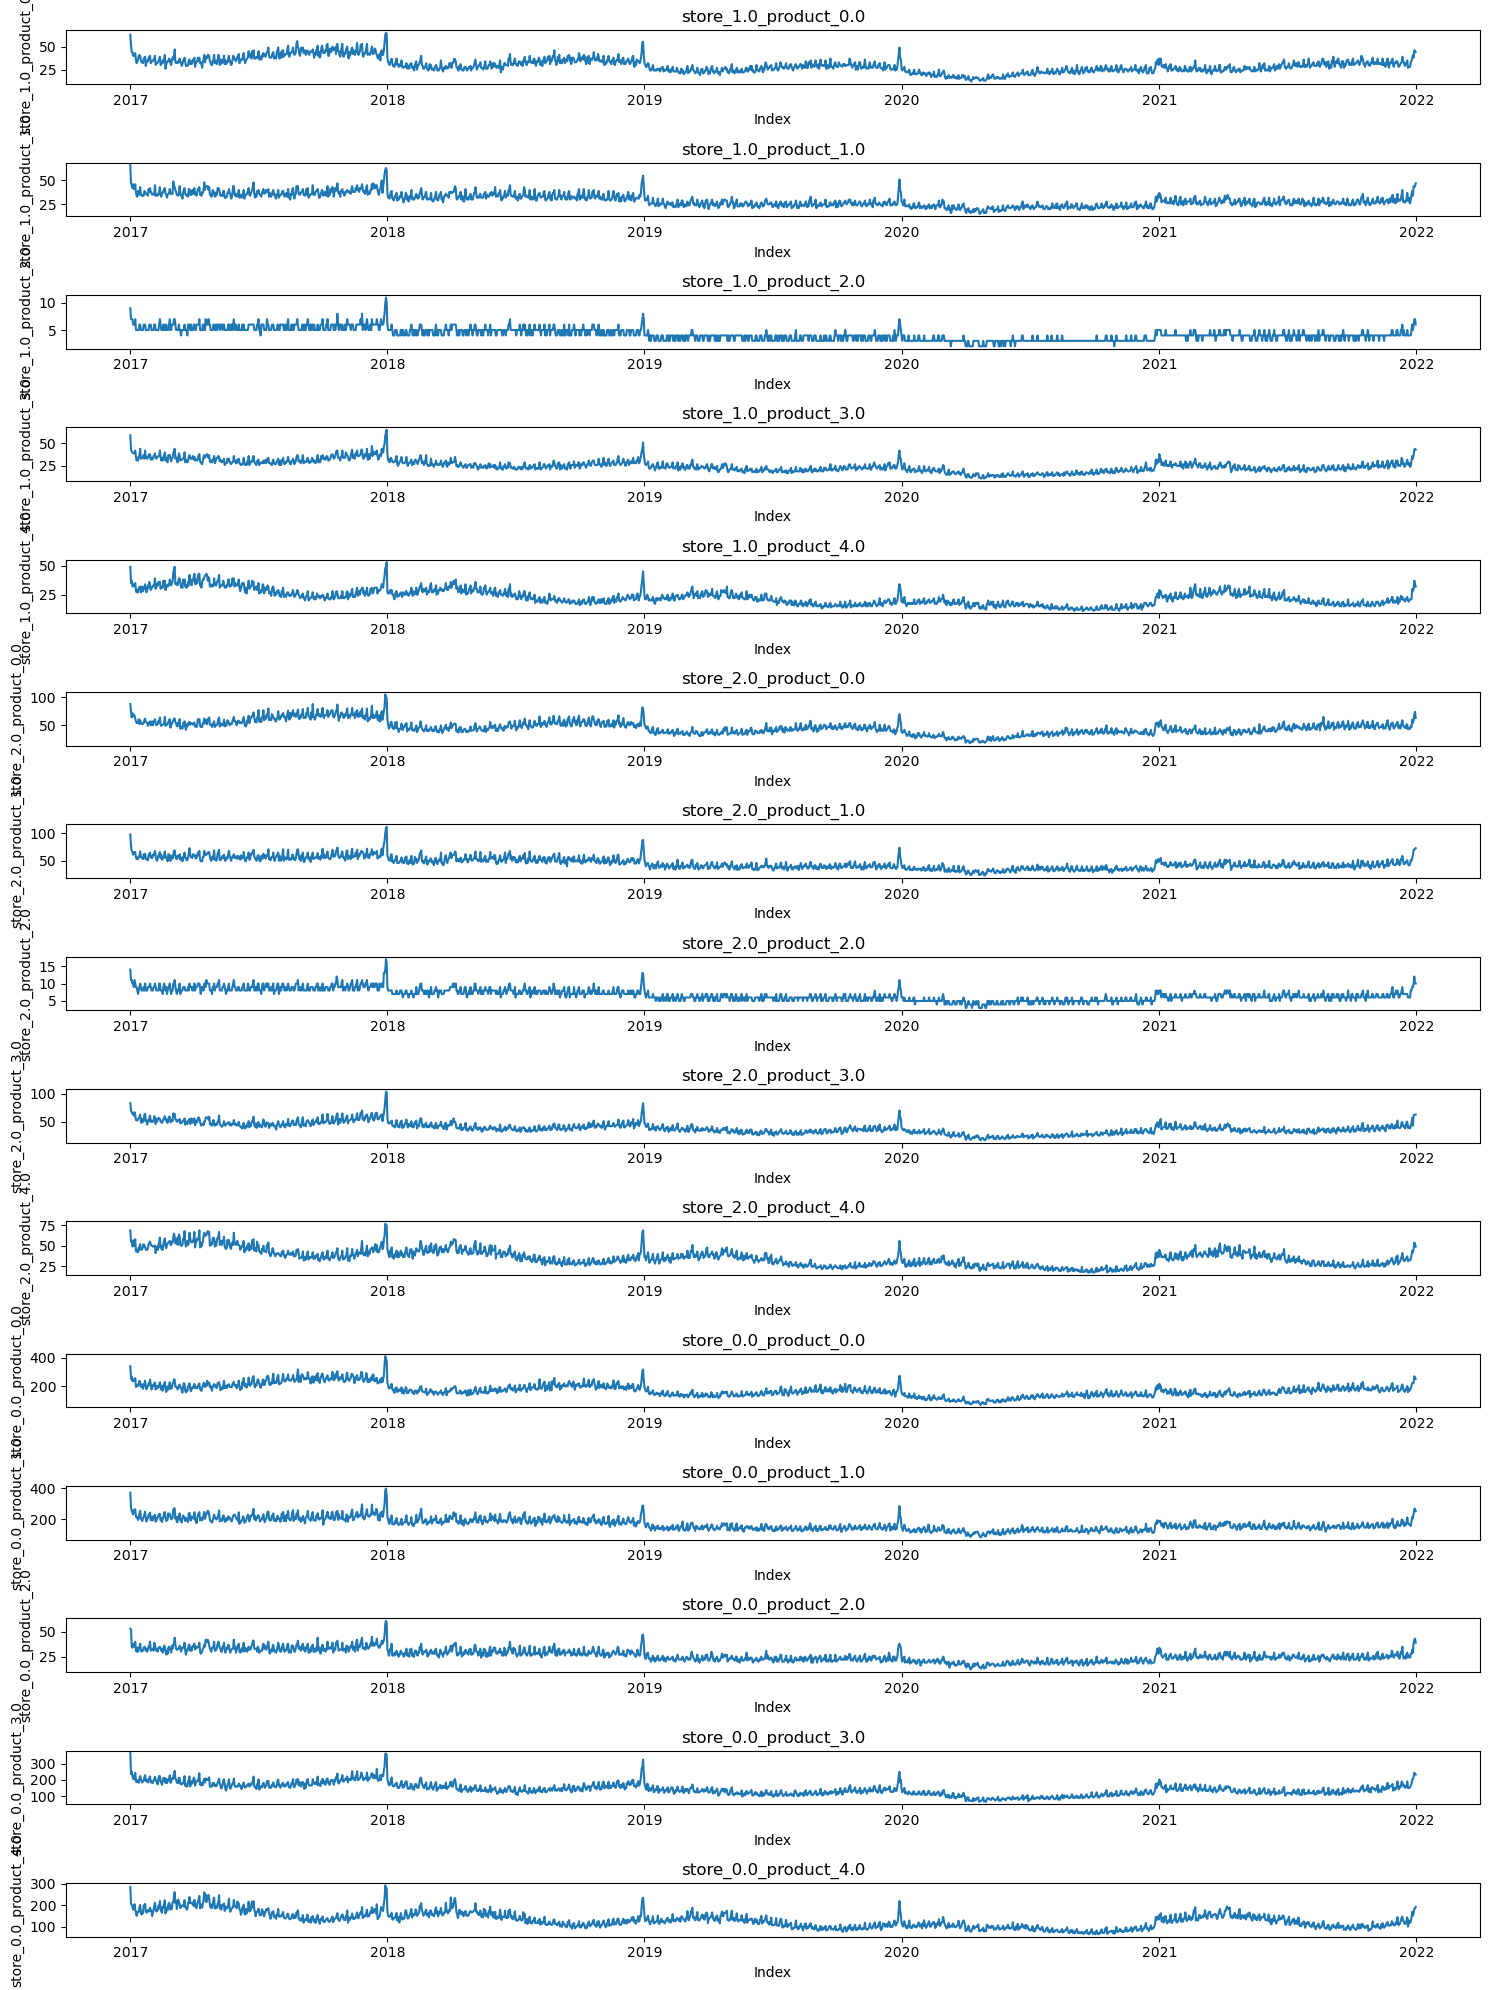

In [11]:
fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 20))

# Iterate over columns and create line charts
for i, (col, ax) in enumerate(zip(df.columns, axes.flat)):
  sns.lineplot(x=df.index, y=df[col], ax=ax)
  ax.set_title(col)
  ax.set_xlabel('Index')
  ax.set_ylabel(col)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [12]:
row_sums = df.sum(axis=1)
df['Total'] = row_sums
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Freq: D
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   store_1.0_product_0.0  1826 non-null   int32
 1   store_1.0_product_1.0  1826 non-null   int32
 2   store_1.0_product_2.0  1826 non-null   int32
 3   store_1.0_product_3.0  1826 non-null   int32
 4   store_1.0_product_4.0  1826 non-null   int32
 5   store_2.0_product_0.0  1826 non-null   int32
 6   store_2.0_product_1.0  1826 non-null   int32
 7   store_2.0_product_2.0  1826 non-null   int32
 8   store_2.0_product_3.0  1826 non-null   int32
 9   store_2.0_product_4.0  1826 non-null   int32
 10  store_0.0_product_0.0  1826 non-null   int32
 11  store_0.0_product_1.0  1826 non-null   int32
 12  store_0.0_product_2.0  1826 non-null   int32
 13  store_0.0_product_3.0  1826 non-null   int32
 14  store_0.0_product_4.0  1826 non-null   int32
 15  Total       

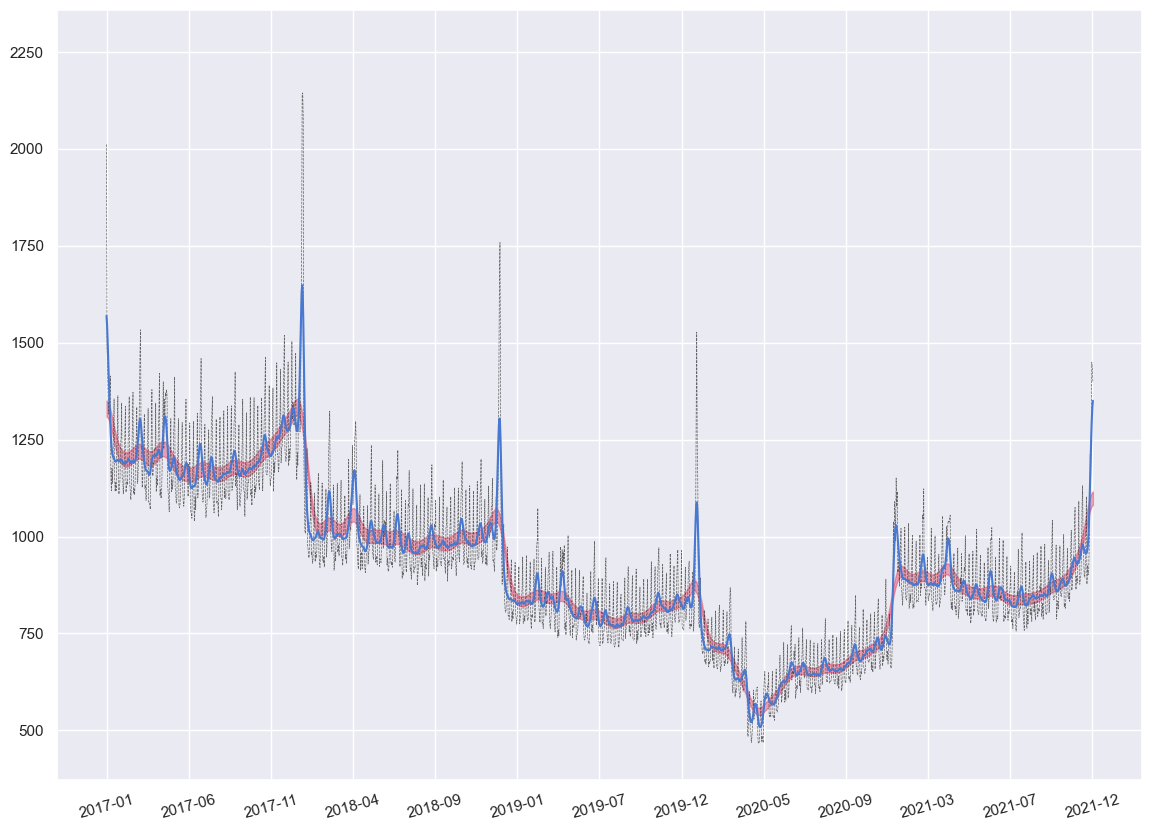

In [13]:
# Calculate the row-wise sum without assigning to a named Series
sns.set(style="darkgrid", palette="muted", color_codes=True)  # Use color_dates for automatic color mapping
fig, ax = plt.subplots(figsize=(14, 10))
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
total_column = df['Total']

# Align data and date range (if necessary)
if len(df) != len(date_range):
    df = df.reindex(date_range, fill_value=np.nan)  # Reindex to match date range

# Select data based on reindexed DataFrame (if necessary)
total_column = df['Total']

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=3)

# Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

Analiza ACF (funkcji autokorelacji):

ACF dostarcza informacji o zależnościach między wartościami szeregu czasowego a jego opóźnieniami, bez usuwania wpływu opóźnień pośrednich.
Istotne wartości ACF dla określonych opóźnień sugerują, że te opóźnienia powinny być uwzględnione w części średniej ruchomej (MA) modelu SARIMAX (parametr q).
Podobnie jak w przypadku PACF, możesz użyć biblioteki statsmodels do obliczenia i wizualizacji ACF.
Testy stacjonarności:

Sprawdź, czy Twój szereg czasowy jest stacjonarny. Możesz to zrobić za pomocą testów statystycznych, takich jak test Dickeya-Fullera (ADF), test Phillipsa-Perrona (PP) lub test KPSS.
Jeśli szereg czasowy jest niestacjonarny, rozważ różnicowanie (parametry d i D w SARIMAX), aby go ustabilizować.
  
Dekompozycja szeregu czasowego:

Przeprowadź dekompozycję szeregu czasowego na składowe: trend, sezonowość i reszty.
Możesz użyć funkcji seasonal_decompose z biblioteki statsmodels.
Analiza składowych pomoże Ci zrozumieć charakter danych i dobrać odpowiednie parametry sezonowe (P, D, Q, s) dla modelu SARIMAX.
Testowanie różnych kombinacji parametrów:

Na podstawie wyników analizy PACF, ACF, testów stacjonarności i dekompozycji, stwórz listę potencjalnych kombinacji parametrów SARIMAX (p, d, q, P, D, Q, s).
Dopasuj modele SARIMAX z różnymi kombinacjami parametrów do danych treningowych.
Oblicz kryteria informacyjne AIC i BIC dla każdego modelu.
Wybór najlepszego modelu:

Wybierz model z najniższymi wartościami AIC i BIC.
Dodatkowo, przeanalizuj reszty modelu. Powinny być one niezależne, losowe i mieć rozkład normalny.
Walidacja modelu:

Przetestuj wybrany model na danych testowych, których nie używałeś do trenowania modelu.
Oceń jakość prognoz na danych testowych za pomocą odpowiednich metryk, takich jak średni błąd kwadratowy (MSE), średni błąd bezwzględny (MAE) lub średni błąd procentowy (MAPE).
Interpretacja i zastosowanie modelu:

Zinterpretuj wyniki modelu i wykorzystaj go do prognozowania przyszłych wartości szeregu czasowego.

## Test Stacjonarności

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss

# Test Dickeya-Fullera (ADF)
adf_result = adfuller(total_column)
print(f'ADF Statistic: {adf_result[0]:.3f}')
print(f'p-value: {adf_result[1]:.3f}')
# Test KPSS
kpss_result = kpss(total_column)
print(f'\nKPSS Statistic: {kpss_result[0]:.3f}')
print(f'p-value: {kpss_result[1]:.3f}')



ADF Statistic: -1.835
p-value: 0.363

KPSS Statistic: 4.390
p-value: 0.010


C:\Users\domin\AppData\Local\Temp\ipykernel_100668\1032864275.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(total_column)


W teście ADF, hipoteza zerowa (H0) zakłada, że szereg czasowy jest niestacjonarny (czyli ma pierwiastek jednostkowy). Wartość p (0.363) jest większa niż typowy poziom istotności (0.05), co oznacza, że nie możemy odrzucić hipotezy zerowej.  
Test ADF nie dostarcza wystarczających dowodów, aby stwierdzić, że szereg czasowy jest stacjonarny.  

W teście KPSS, hipoteza zerowa (H0) zakłada, że szereg czasowy jest stacjonarny wokół trendu deterministycznego. Wartość p (0.010) jest mniejsza niż typowy poziom istotności (0.05), co oznacza, że odrzucamy hipotezę zerową.  
Test KPSS sugeruje, że szereg czasowy jest niestacjonarny.  

*  Test ADF nie wskazuje na stacjonarność szeregu czasowego.  
*  Test KPSS wskazuje na niestacjonarność szeregu czasowego.

Szereg czasowy jest niestacjonarny. 

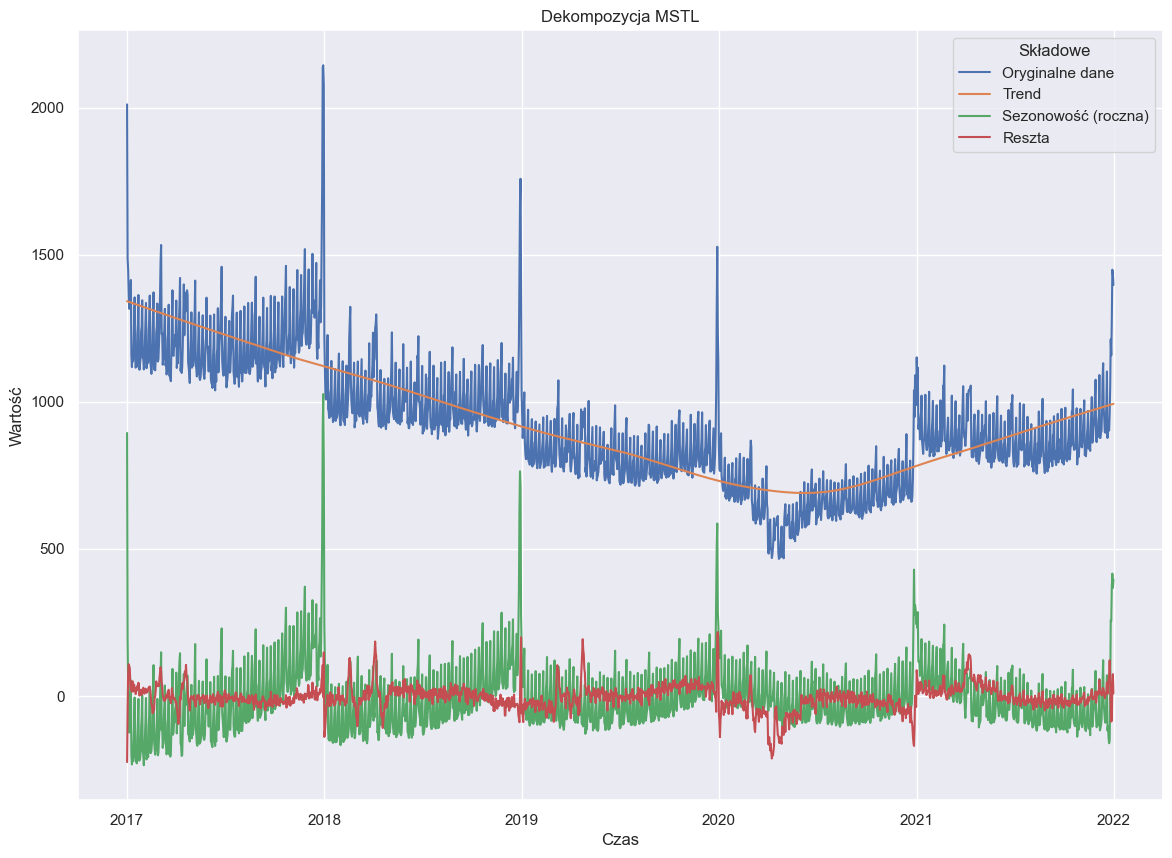

In [15]:
from statsmodels.tsa.seasonal import MSTL, DecomposeResult

# Dekompozycja MSTL
mstl = MSTL(total_column, periods=[364])  # Zakładamy sezonowość roczną (365 dni)
result = mstl.fit()

# Przygotowanie danych do wizualizacji w seaborn
df_results = pd.DataFrame({
    'Oryginalne dane': total_column,
    'Trend': result.trend,
    'Sezonowość (roczna)': result.seasonal,
    'Reszta': result.resid
})
df_results = df_results.stack().reset_index()  # Przekształcenie do formatu "długiego"
df_results.columns = ['Czas', 'Składowa', 'Wartość']

df_results.to_csv('MSTL.txt')
# Wizualizacja z seaborn
sns.set_theme(style="darkgrid")

plt.figure(figsize=(14, 10))
sns.lineplot(x='Czas', y='Wartość', hue='Składowa', data=df_results)
plt.title('Dekompozycja MSTL')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.legend(title='Składowe')
plt.show()

# Opcjonalnie: Możesz wyświetlić podsumowanie dekompozycji, ale funkcja summary() nie jest jeszcze dostępna
# w statsmodels dla obiektów DecomposeResult. Możesz śledzić rozwój tej funkcjonalności.
# print(result.summary())  

1.  Trend: linia trendu pokazuje ogólną tendencję zmian wartości w czasie po usunięciu sezonowości. Trend nie jest liniowy, ale raczej wykazuje zmianę w drugiej połowie okresu obserwacji.
   
2.  Sezonowość (roczna): składowa sezonowa przedstawia powtarzające się wzorce w danych, które występują w stałych odstępach czasu (w tym przypadku co roku). Na wykresie widać, że sezonowość ma dużą amplitudę, co oznacza, że różnice między wartościami w poszczególnych okresach są znaczne. Szczególnie wyraźny jest wzrost wartości pod koniec każdego roku, co może sugerować np. sezonowy charakter sprzedaży lub inny czynnik wpływający na dane w tym okresie.
   
3. Reszta: składowa resztowa zawiera pozostałości po usunięciu trendu i sezonowości z oryginalnych danych. Powinna ona reprezentować losowy szum lub nieregularne wahania, które nie są wyjaśnione przez trend ani sezonowość. Na wykresie widać, że reszty mają stosunkowo niewielką amplitudę w porównaniu do oryginalnych danych i składowej sezonowej, co sugeruje, że model MSTL dobrze wyjaśnia większość zmienności w danych. Warto jednak zwrócić uwagę na kilka większych odchyleń reszt, które mogą wskazywać na obecność nietypowych zdarzeń lub anomalii w danych.

## Analiza ACF (funkcji autokorelacji):

## Częściowa funkcja autokorelacji (PACF)

In [40]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import numpy as np

# Obliczanie maksymalnej dopuszczalnej liczby opóźnień
nobs = len(df)
max_nlags = nobs - 1

# Wybór liczby opóźnień
nlags = min(480, max_nlags)

# Obliczanie PACF różnymi metodami
pacf_ols = sm.tsa.stattools.pacf_ols(total_column, nlags=nlags)
pacf_yw = sm.tsa.stattools.pacf_yw(total_column, nlags=nlags)
pacf_lev = sm.tsa.stattools.levinson_durbin_pacf(pacf_ols, nlags=nlags) 
pacf_lev = pacf_lev[1]  # Extract only the pacf values

# Obliczanie granic przedziału ufności
conf_int = 2.33 / np.sqrt(len(df))

# Tworzenie DataFrame dla PACF OLS, Yule-Walkera i Levinson-Durbin
pacf_ols_df = pd.DataFrame({'lag': range(len(pacf_ols)), 'PACF_ols': pacf_ols})
pacf_yw_df = pd.DataFrame({'lag': range(len(pacf_yw)), 'PACF_yw': pacf_yw})
pacf_lv_df = pd.DataFrame({'lag': range(len(pacf_lev)), 'PACF_lv': pacf_lev})

# Dodanie kolumn oznaczających istotność 
pacf_ols_df['is_significant_positive_ols'] = pacf_ols_df['PACF_ols'] > conf_int
pacf_ols_df['is_significant_negative_ols'] = pacf_ols_df['PACF_ols'] < -conf_int

pacf_yw_df['is_significant_positive_yw'] = pacf_yw_df['PACF_yw'] > conf_int
pacf_yw_df['is_significant_negative_yw'] = pacf_yw_df['PACF_yw'] < -conf_int

pacf_lv_df['is_significant_positive_lv'] = pacf_lv_df['PACF_lv'] > conf_int  # Corrected column name
pacf_lv_df['is_significant_negative_lv'] = pacf_lv_df['PACF_lv'] < -conf_int  # Corrected column name

# Filter and sort the dataframes
filtered_pacf_ols_df = pacf_ols_df[
(pacf_ols_df['PACF_ols'] > conf_int) | (pacf_ols_df['PACF_ols'] < -conf_int)
].sort_values(by='PACF_ols', ascending=False, key=abs)

filtered_pacf_yw_df = pacf_yw_df[
(pacf_yw_df['PACF_yw'] > conf_int) | (pacf_yw_df['PACF_yw'] < -conf_int)
].sort_values(by='PACF_yw', ascending=False, key=abs)

filtered_pacf_lv_df = pacf_lv_df[
(pacf_lv_df['PACF_lv'] > conf_int) | (pacf_lv_df['PACF_lv'] < -conf_int)
].sort_values(by='PACF_lv', ascending=False, key=abs)

# Create selection using newer function and correct empty value
nearest = alt.selection_point(nearest=True, on='mouseover',fields=['lag'], empty=False)

# Create base chart for both methods
base = alt.Chart().encode(
x=alt.X('lag:O', axis=alt.Axis(labelAngle=-45), title='Lag'),tooltip=['lag','PACF'])

# Charts for each method
bar_ols = base.mark_bar(color='steelblue').encode(
y=alt.Y('PACF_ols:Q', title='PACF (OLS)'),
tooltip = ['lag','PACF_ols']
).properties(
data=filtered_pacf_ols_df
)

bar_yw = base.mark_bar(color='skyblue').encode(
y=alt.Y('PACF_yw:Q', title='PACF (Yule-Walker)'),
tooltip = ['lag','PACF_yw']
).properties(
data=filtered_pacf_yw_df
)

bar_lv = base.mark_bar(color='blue').encode(
y=alt.Y('PACF_lv:Q', title='PACF (Levinson-Durbin)'),
tooltip = ['lag','PACF_lv']
).properties(
data=filtered_pacf_lv_df
)

# Interactive elements function (modified to use 'nearest')
def add_interactive_elements(chart, pacf_column):
# Transparent selectors across the chart.
  selectors = chart.mark_point().encode(
  x='lag:O',
  opacity=alt.value(0),
  ).add_params(
  nearest
  )
  # Draw points on the line, and highlight based on selection
  points = chart.mark_point().encode(
  opacity=alt.condition(nearest, alt.value(1), alt.value(0))
  )

# Draw text labels near the points, and highlight based on selection
  text = chart.mark_text(align='left', dx=5, dy=-5).encode(
  text=alt.condition(nearest, f'{pacf_column}:Q', alt.value(' '))
  )

  # Draw a rule at the location of the selection
  rules = chart.mark_rule(color='gray').encode(
  x='lag:O',
  ).transform_filter(
  nearest
  )

  return alt.layer(
   chart, selectors, points, rules, text
  ).properties(
   width=1000, height=450
  ).interactive()

chart_ols = add_interactive_elements(bar_ols, 'PACF_ols')
chart_yw = add_interactive_elements(bar_yw, 'PACF_yw')
chart_lv = add_interactive_elements(bar_lv, 'PACF_lv')

# Combine the plots
chart = alt.vconcat(chart_ols, chart_yw, chart_lv)
display(chart)

# Wyświetlanie tabel
print("Most Significant PACF Values (OLS):\n")
print(filtered_pacf_ols_df[['lag', 'PACF_ols']].head(32).to_markdown(index=False,numalign="left", stralign="left"))

print("\nMost Significant PACF Values (Yule-Walker):\n")
print(filtered_pacf_yw_df[['lag', 'PACF_yw']].head(32).to_markdown(index=False,numalign="left", stralign="left"))

print("\nMost Significant PACF Values (Levinson-Durbin):\n")
print(filtered_pacf_lv_df[['lag', 'PACF_lv']].head(32).to_markdown(index=False,numalign="left", stralign="left"))


alt.VConcatChart(...)

Most Significant PACF Values (OLS):

| lag   | PACF_ols   |
|:------|:-----------|
| 0     | 1          |
| 1     | 0.908255   |
| 8     | -0.700558  |
| 7     | 0.409766   |
| 5     | 0.337037   |
| 10    | 0.303519   |
| 15    | -0.296898  |
| 9     | 0.29062    |
| 366   | -0.246538  |
| 22    | -0.226136  |
| 4     | 0.223191   |
| 365   | -0.197636  |
| 16    | 0.195137   |
| 6     | 0.192116   |
| 362   | 0.157968   |
| 17    | 0.156623   |
| 29    | -0.156422  |
| 31    | 0.149308   |
| 360   | 0.148276   |
| 38    | 0.127368   |
| 24    | 0.124555   |
| 11    | 0.121159   |
| 36    | -0.115914  |
| 361   | 0.114605   |
| 23    | 0.113911   |
| 43    | -0.108295  |
| 367   | -0.0964276 |
| 50    | -0.0951937 |
| 45    | 0.0899223  |
| 71    | -0.0889088 |
| 14    | 0.0853676  |
| 44    | 0.0810277  |

Most Significant PACF Values (Yule-Walker):

| lag   | PACF_yw   |
|:------|:----------|
| 461   | -4.15284  |
| 459   | 1.55478   |
| 462   | 1.29066   |
| 460   | -1.28995  |
| 0

## AutoARIMA sktime

In [17]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(max_d=2, max_p=8, max_q=8, max_P=6, max_D=2, max_Q=6, sp=18)  
# forecaster.fit(df['Total'])
# forecaster.summary()
#RAAAAAAAAAAAAAAAAAAMU potrzeba 
# (S)ARIMA(X) hyper-parameters (p, d, q, P, D, Q).

## Znaleźenie minium funkcyjnego wykorzystując Optune

In [20]:
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import optuna

y= df['Total']
# Data Splitting (SlidingWindowSplitter)
cv = SlidingWindowSplitter(window_length=441, step_length= 400, fh=np.arange(0,400))

# Definiowanie funkcji celu dla Optuny
def objective(trial):
    p = trial.suggest_int("p", 1, 4)
    d = trial.suggest_int("d", 0, 1)
    q = trial.suggest_int("q", 1, 4)
    P = trial.suggest_int("P", 4, 8)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 4, 8)
    mape_values = []
    for train_index, test_index in cv.split(y):
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        try:
            forecaster = SARIMAX( order=(p, d, q), seasonal_order=(P, D, Q, 364), trend='ct',  maxiter=25, method = 'basinhopping', enforce_stationarity= False)
            forecaster = forecaster.set_config(warnings='off', backend='dask')
            forecaster = forecaster.fit(y_train) # Usunięcie suppress_warnings
            fh = ForecastingHorizon(y_test.index, is_relative=False)
            y_pred = forecaster.predict(fh)

            if np.isnan(y_pred).any():  # Sprawdzenie, czy prognozy nie zawierają NaN
                return float('inf')  # Zwróć nieskończoność w przypadku NaN

            mape_values.append(mean_absolute_percentage_error(y_test, y_pred))
        except Exception as e:
            print(f"Error for params {trial.params}: {e}")  # Poprawka: trial.params
            return float('inf')  # Zwróć nieskończoność w przypadku błędu

    return np.mean(mape_values)  # Zwróć średnią wartość MAPE

# Tworzenie obiektu study Optuna
study = optuna.create_study(direction="minimize")

# Optymalizacja
study.optimize(objective, n_trials=100)  # Dostosuj liczbę prób (n_trials)

# Wyniki
print("Najlepsze parametry:", study.best_params)
print("Najlepszy MAPE (średnia z walidacji krzyżowej):", study.best_value)


[I 2024-06-02 17:10:28,858] A new study created in memory with name: no-name-36e83983-0c55-449c-a1b6-3b22d94016ee
C:\Users\domin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\domin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
[W 2024-06-02 17:26:30,447] Trial 0 failed with parameters: {'p': 4, 'd': 1, 'q': 3, 'P': 8, 'D': 1, 'Q': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\domin\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^

KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier, Seasonality
from statsmodels.tsa.api import SARIMAX

four = Fourier(period=5*365, order=3)
seas = Seasonality(period=365)
# Assuming 'train' is your DataFrame with 'num_sold_scaled' as the target variable
det_proc = DeterministicProcess(df.index, additional_terms=[ seas, four])
#det_proc.in_sample()


## SARIMAX

In [ ]:
# model = SARIMAX(df['Total'],
#                      order=(8, 0, 12),  # Adjust order parameters as needed
#                      seasonal_order=(8, 1, 8, 32),  # Adjust seasonal order as needed
#                      exog=det_proc.in_sample())
# #
# SARIMAX_fit = model.fit()
# #print(SARIMAX_fit.summary())
# forecast_results = SARIMAX_fit.forecast(steps=800, exog=det_proc.out_of_sample(800))  # Forecast for 12 steps (e.g., 12 months)
# forecast_df = pd.DataFrame(forecast_results)



# fig, ax = plt.subplots(figsize=(14, 10))
# # Plot lines and shaded area
# ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
# ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
# ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex
# ax.plot(forecast_df.index, forecast_df['predicted_mean'], label='Forecast')
# # Adjust y-axis limits based on 'Total' column
# ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
#             np.max(total_column) + (np.max(total_column) * 10) / 100)


# num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
# date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
# tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
# ax.set_xticks(date_range[tick_positions])
# date_format = "%Y-%m"
# formatter = mdates.DateFormatter(date_format)

# # Ustaw formater dla osi x
# ax.xaxis.set_major_formatter(formatter)

# # Rotates x-axis labels for better readability with many dates
# plt.xticks(rotation=15)
# plt.show()

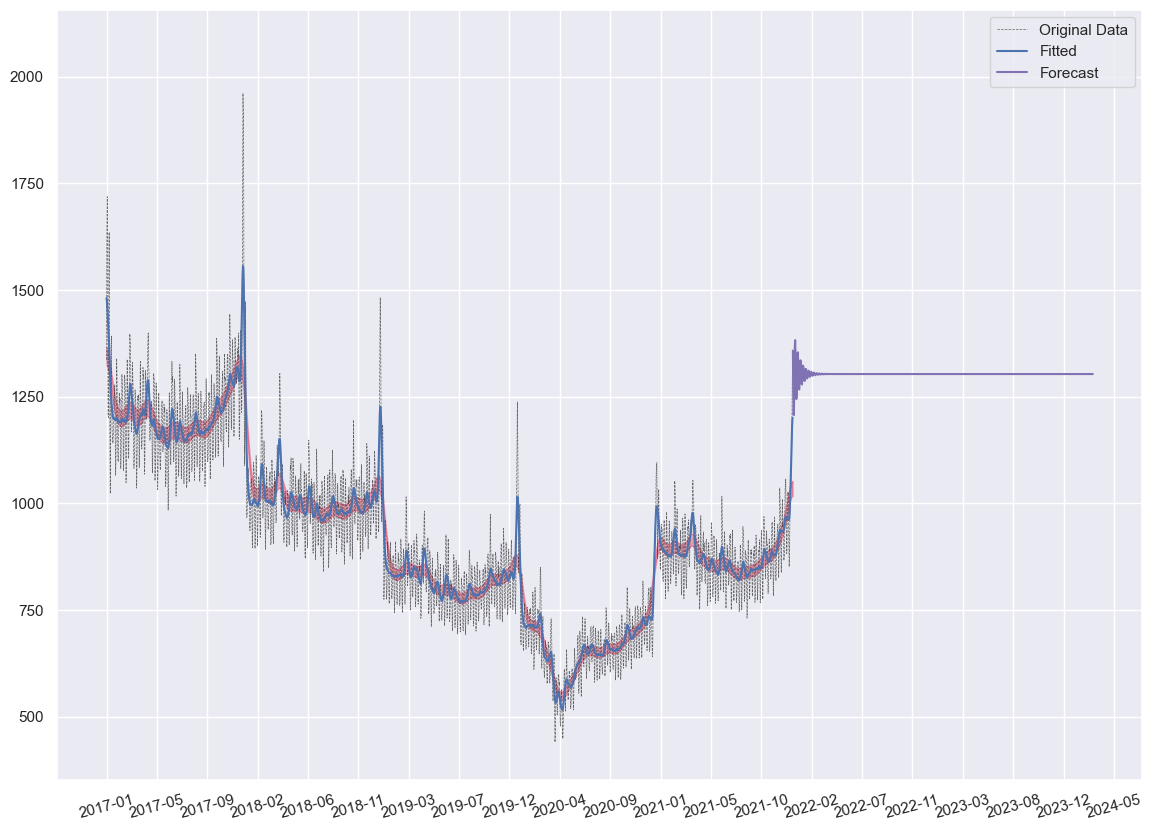

In [42]:
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon

model = TBATS(sp=32)
forecaster = model.fit(y=df['Total'])
fh = ForecastingHorizon(df['Total'].index, is_relative=False) # assuming y is your training data

values = forecaster.predict(fh=fh, X=None) 
pred = forecaster.predict(fh=np.arange(1, 800))

fig, ax = plt.subplots(figsize=(14, 10))

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(values.to_numpy(), sigma=3)

# Error formatting 
upper_err = gaussian_filter1d(values.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(values.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(values.index, values, '--', linewidth=0.5, color='k', alpha=0.65, label='Original Data') 
ax.plot(values.index, Final_array_smooth, label='Fitted')  
ax.fill_between(values.index, upper_err, lower_err, color='crimson', alpha=0.35) 
ax.plot(pred.index, pred[:],color='m', label='Forecast') 

# Adjust y-axis limits based on 'values'
ax.set_ylim(np.min(values) - (np.min(values) * 20) / 100,
            np.max(values) + (np.max(values) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
num_ticks = 20 # Adjust this for the desired number of ticks

# Set x-axis ticks and format
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=15)  

plt.legend()
plt.show()



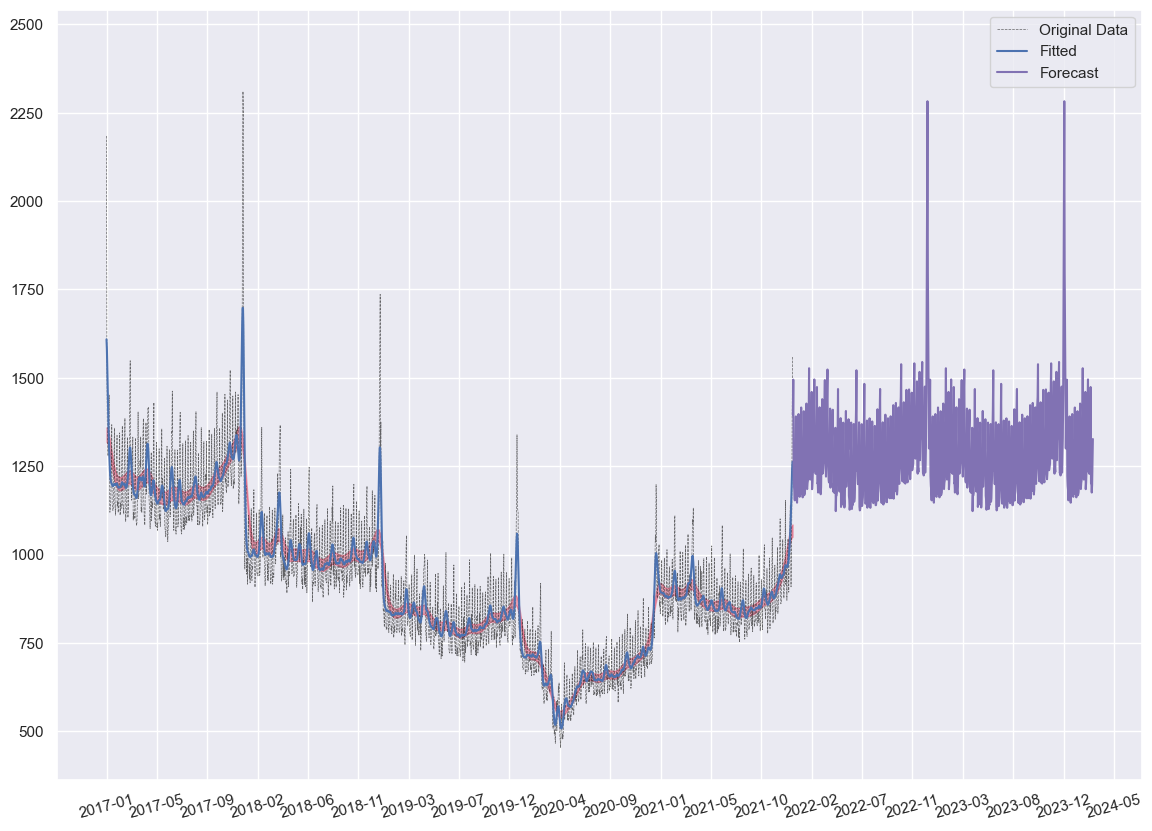

In [22]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Set smoothing parameters (adjust alpha, beta, gamma as needed)
alpha = 0.95  # Smoothing level parameter (0 < alpha <= 1)
beta = 0.555  # Trend smoothing parameter (0 for no trend, 0 < beta < 1 for trend)
gamma = 0.25  # Seasonal smoothing parameter (0 < gamma <= 1)




model = ExponentialSmoothing(sp=364, seasonal='mul', initialization_method = 'estimated',  smoothing_level=alpha, smoothing_trend= beta, smoothing_seasonal= gamma)
forecaster = model.fit(y=df['Total'])
pred = forecaster.predict(fh=np.arange(1, 800))

values = forecaster._fitted_forecaster.fittedvalues

fig, ax = plt.subplots(figsize=(14, 10))

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(values.to_numpy(), sigma=3)

# Error formatting 
upper_err = gaussian_filter1d(values.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(values.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(values.index, values, '--', linewidth=0.5, color='k', alpha=0.65, label='Original Data') 
ax.plot(values.index, Final_array_smooth, label='Fitted')  
ax.fill_between(values.index, upper_err, lower_err, color='crimson', alpha=0.35) 
ax.plot(pred.index, pred[:],color='m', label='Forecast') 

# Adjust y-axis limits based on 'values'
ax.set_ylim(np.min(values) - (np.min(values) * 20) / 100,
            np.max(values) + (np.max(values) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
num_ticks = 20 # Adjust this for the desired number of ticks

# Set x-axis ticks and format
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=15)  

plt.legend()
plt.show()

In [ ]:
#--

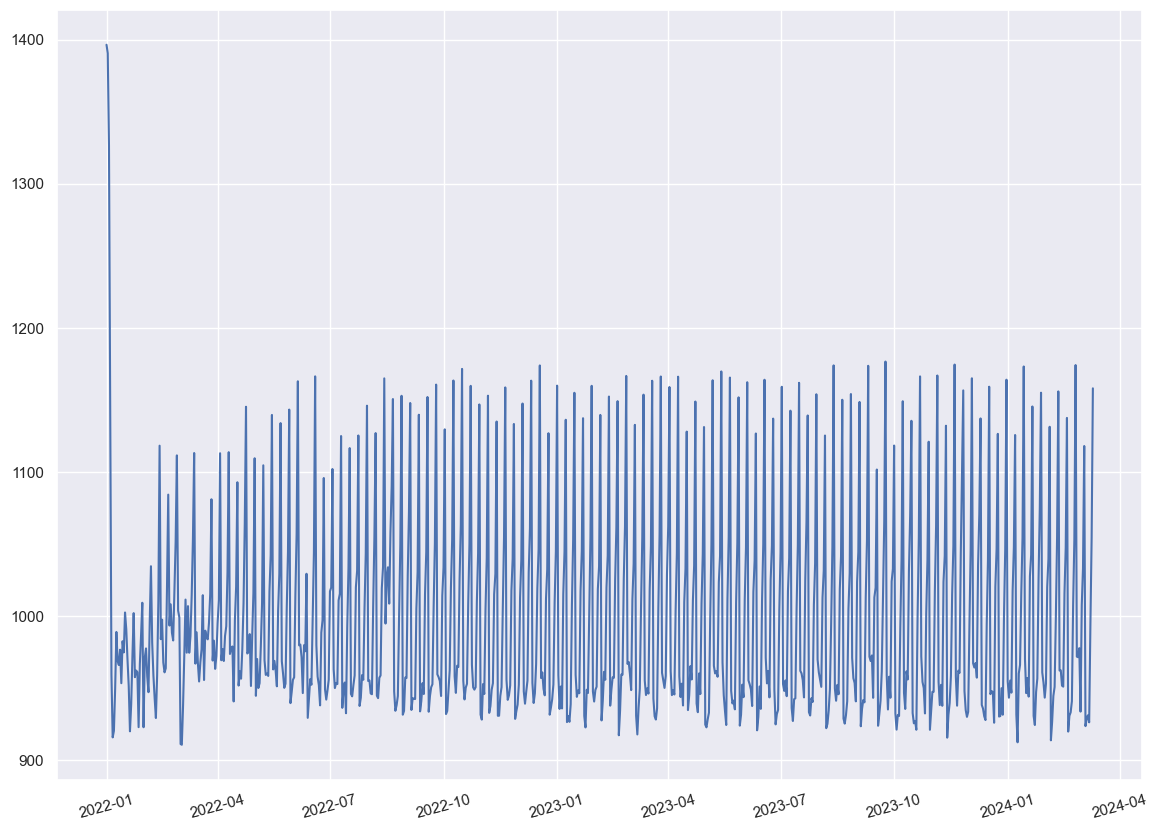

In [39]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
                 regressor       = XGBRegressor(random_state=123),
                 lags            = 72,
                 differentiation = None
             )

forecaster.fit(y=df['Total'])
forecast_df=forecaster.predict(steps=800)

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(forecast_df.index, forecast_df[:], label='Forecast')

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [52]:
df["Total"] = df["Total"].astype(np.float32)

2017-01-01    2011
2017-01-02    1487
2017-01-03    1448
2017-01-04    1357
2017-01-05    1316
              ... 
2021-12-27    1158
2021-12-28    1280
2021-12-29    1449
2021-12-30    1434
2021-12-31    1397
Freq: D, Name: Total, Length: 1826, dtype: int64

In [63]:
cv

SlidingWindowSplitter(fh=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106,...
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
       351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363,
       364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376,
       377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399]),
                      step_length=400, window_length=441)

In [78]:
df['trend_bin']

2017-01-01    4
2017-01-02    4
2017-01-03    4
2017-01-04    4
2017-01-05    4
             ..
2021-12-27    4
2021-12-28    4
2021-12-29    4
2021-12-30    4
2021-12-31    4
Freq: D, Name: trend_bin, Length: 1826, dtype: int64

In [85]:
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

df["Total"] = df["Total"].astype(np.float32)


def objective(trial):
    """Funkcja celu dla optymalizacji Optuna."""

    # Hiperparametry do optymalizacji (bez zmian)
    lags = trial.suggest_int("lags", 1, 50)
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    epochs = trial.suggest_int("epochs", 10, 100)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # TimeSeriesSplit (bez zmian)
    splitter = TimeSeriesSplit(n_splits=3, test_size=0.2)

    errors = []

    for train_index, test_index in splitter.split(df, df['Total']):
        test_start = int(n_samples - n_splits * test_size)  # Convert to int
        test_starts = range(test_start, n_samples, int(test_size))  # Convert to int
        levels = y_train.columns.tolist()

        # Oblicz horyzont prognozowania
        fh = np.arange(1, len(y_test) + 1)

        # Tworzenie i kompilacja modelu (bez zmian)
        model = create_and_compile_model(
            series=y_train,
            lags=lags,
            steps=800,
            recurrent_layer="LSTM",
            recurrent_units=[lstm_units] * 3,
            dense_units=[dense_units] * 3,
            optimizer=Adam(learning_rate=0.0125),
            loss=MeanSquaredError()
        )

        # Tworzenie obiektu ForecasterRnn
        forecaster = ForecasterRnn(
            regressor=model,
            levels=levels,
            fit_kwargs={
                "epochs": epochs,
                "batch_size": batch_size,
            },
        )

        forecaster.fit(y_train)
        predictions = forecaster.predict(fh)  # Użyj obliczonego fh

        # Konwersja y_test do Series (jeśli to konieczne)
        if isinstance(y_test, pd.DataFrame):
            y_test = y_test.iloc[:, 0]

        metric = MeanSquaredError(y_test, predictions)
        errors.append(metric)

    return np.mean(errors)

# Utworzenie badania Optuna i optymalizacja (bez zmian)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # 100 prób optymalizacji

print("Najlepsze parametry:", study.best_params)

fig, ax = plt.subplots(figsize=(14, 10))
# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(values.to_numpy(), sigma=3)

# Error formatting 
upper_err = gaussian_filter1d(values.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(values.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(values.index, values, '--', linewidth=0.5, color='k', alpha=0.65, label='Original Data') 
ax.plot(values.index, Final_array_smooth, label='Fitted')  
ax.fill_between(values.index, upper_err, lower_err, color='crimson', alpha=0.35) 
ax.plot(predictions.index, predictions[:],color='m', label='Forecast') 

# Adjust y-axis limits based on 'values'
ax.set_ylim(np.min(values) - (np.min(values) * 20) / 100,
            np.max(values) + (np.max(values) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
num_ticks = 20 # Adjust this for the desired number of ticks

# Set x-axis ticks and format
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=15)  

plt.legend()
plt.show()
                                 

[I 2024-06-02 19:09:52,098] A new study created in memory with name: no-name-afbaa182-7fc4-4cc9-909b-541e760ff1b7
[W 2024-06-02 19:09:52,100] Trial 0 failed with parameters: {'lags': 1, 'lstm_units': 32, 'dense_units': 64, 'epochs': 31, 'batch_size': 64} because of the following error: TypeError("'float' object cannot be interpreted as an integer").
Traceback (most recent call last):
  File "C:\Users\domin\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\domin\AppData\Local\Temp\ipykernel_100668\1150450976.py", line 27, in objective
    for train_index, test_index in splitter.split(df, df['Total']):
  File "C:\Users\domin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py", line 1188, in split
    test_starts = range(n_samples - n_splits * test_size, n_samples, test_size)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError:

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
from sktime.forecasting.neuralforecast import NeuralForecastLSTM
from sktime.forecasting.stream import UpdateEvery

from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter
from sktime.split import CutoffSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.base import ForecastingHorizon
import torch.optim as optim

# Select data based on reindexed DataFrame (if necessary)
total_column = df['Total']

# Assuming df is your DataFrame, convert the 'Total' column to a Series
if not isinstance(df['Total'], pd.Series):
    y = pd.Series(df['Total'])
else:
    y = df['Total']

# Ensure the index is a DatetimeIndex
if not isinstance(y.index, pd.DatetimeIndex):
    # Assuming the index represents dates, try to convert it
    y.index = pd.to_datetime(y.index)

window_length = 438
fh_out = np.arange(1, 101) 

cv = CutoffSplitter(
    cutoffs=np.arange(window_length, len(y), 143),
    fh=fh_out,
    window_length=window_length
)

all_results = []
previous_weights = None  

# NeuralForecastLSTM Model (created before the loop)
model = NeuralForecastLSTM(
    encoder_n_layers=4,
    encoder_hidden_size = 350,
    encoder_dropout=0.15,
    batch_size=288,
    max_steps=450, 
    optimizer = optim.Rprop
)
update_every = fh_out
wrapped_model = UpdateEvery(model, update_interval=update_every)

# # Cross-Validation Loop
# for fold_idx, (train_index, test_index) in enumerate(cv.split(df['Total']), start=1):
#     y_train, y_test = df['Total'].iloc[train_index], df['Total'].iloc[test_index]
#     fh = ForecastingHorizon(y_test.index, is_relative=False)

#     wrapped_model.fit(y=y_train, X=None, fh= fh)

#     y_pred = wrapped_model.predict(fh= fh)
#     results = MeanAbsolutePercentageError().evaluate(y_test, y_pred)
#     all_results.append(results)

#         # Plot actual vs. predicted values
#     plt.figure(figsize=(12, 6))
#     plt.plot(y_train.index, y_train, label="Train")
#     plt.plot(y_test.index, y_test, label="Actual")
#     plt.plot(y_pred.index, y_pred, label="Predicted")
#     plt.title(f"Fold {fold_idx} - Actual vs. Predicted")
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.show()

# # Results - Calculate Mean MAPE Across Folds
# average_mape = np.mean([np.mean(r) for r in all_results])
# print(f"\nAverage MAPE (across folds): {average_mape:.2f}") 


wrapped_model.fit(y=y, X=None, fh=np.arange(1, 480)) 
NFLSTM = wrapped_model.predict(fh=np.arange(1, 480))

fig, ax = plt.subplots(figsize=(14, 10))

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=3)

# Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex
ax.plot(NFLSTM.index, NFLSTM[:], label='Fit')

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)

date_range = pd.date_range(start='2017-01-01', end='2024-05-15', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

#Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

In [ ]:
from sktime.split import CutoffSplitter
from sktime.forecasting.base import ForecastingHorizon

window_length = 438  
fh_out = np.arange(1, 101)  # Reduced forecast horizon to 100 steps

cv = CutoffSplitter(
    cutoffs=np.arange(window_length, len(y), 143),  
    fh=fh_out, 
    window_length=window_length
)

print("Number of data points:", len(y))
print("Cutoffs:", cv.get_cutoffs(y))
print("Max cutoff:", cv.get_cutoffs(y)[-1])
print("fh:", fh_out)
print("Max fh:", max(fh_out))


all_results = []  # List to store all evaluation results

# Cross-Validation Loop
for fold_idx, (train_index, test_index) in enumerate(cv.split(df['Total'])):
    print(f"\nStarting Fold {fold_idx}...")
    print(f"  Train data shape: {df['Total'].iloc[train_index].shape}")
    print(f"  Test data shape: {df['Total'].iloc[test_index].shape}")
    
    # Display start and end indices for training and test sets
    print("  Train data indices:", train_index[0], "-", train_index[-1])
    print("  Test data indices:", test_index[0], "-", test_index[-1])
    
    y_train, y_test = df['Total'].iloc[train_index], df['Total'].iloc[test_index]
    fh = ForecastingHorizon(y_test.index, is_relative=False)